1.Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
yes, we can see the target are mostly concented above 4000,and mostly distributed around dead numbers.
2.Can you make a bar plot or a histogram?
yes, I did, show as below.
3.Can you make a scatterplot?
yes, I did, show as below.
4.Can you compare two related quantities?
I researched the correlations among variables and it is showed below.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
color = sns.color_palette()
%matplotlib inline

#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

In [4]:
data = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
target = np.log1p(data['target'].values)

In [5]:
print ("Training set:")
n_data  = len(data)
n_features = data.shape[1]
print ("Number of Records: {}".format(n_data))
print ("Number of Features: {}".format(n_features))

# testing set
print ("\nTesting set:")
n_data  = len(test)
n_features = test.shape[1]
print ("Number of Records: {}".format(n_data))
print ("Number of Features: {}".format(n_features))

Training set:
Number of Records: 4459
Number of Features: 4993

Testing set:
Number of Records: 49342
Number of Features: 4992


In [6]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


Text(0.5, 1.05, 'Data Sparse Visualizing')

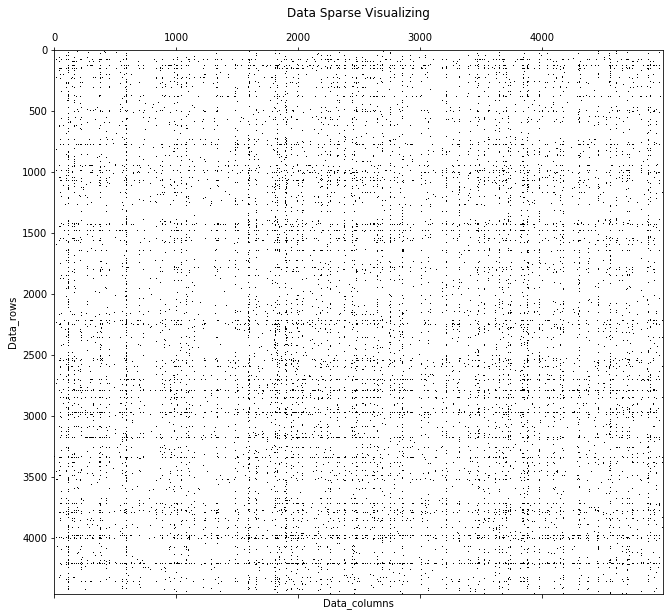

In [28]:
%matplotlib inline
plt.figure(figsize=(15,10))
feat_df = data.drop(['ID','target'],axis=1)
plt.spy(feat_df)
plt.xlabel('Data_columns')
plt.ylabel('Data_rows')
plt.title('Data Sparse Visualizing')

In [30]:
sparse_count = {}
for col in feat_df.columns:
    sparse_count[col] = sum(feat_df[col] != 0)
sparse_count_df = pd.Series(sparse_count)
sparse_count_df.head()

48df886f9    39
0deb4b6a8     4
34b15f335    33
a8cb14b00     2
2f0771a37     5
dtype: int64

In [34]:
sparse_count_df.sort_values()

24a233e8f       0
b281a62b9       0
00fcf67e4       0
e37b65992       0
833b35a7c       0
             ... 
0572565c2    1547
c47340d97    1555
91f701ba2    1560
c5a231d81    1565
0ff32eb98    1565
Length: 4991, dtype: int64

In [16]:
unique_df = data.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
unique_df['value'] = [data[x][0] for x in data.columns]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 3)

In [36]:
number_zeros = data.apply(lambda x : sum(x == 0), axis = 0)
number_zeros

ID              0
target          0
48df886f9    4420
0deb4b6a8    4455
34b15f335    4426
             ... 
71b203550    4424
137efaa80    4441
fb36b89d9    4425
7e293fbaf    4379
9fc776466    4296
Length: 4993, dtype: int64

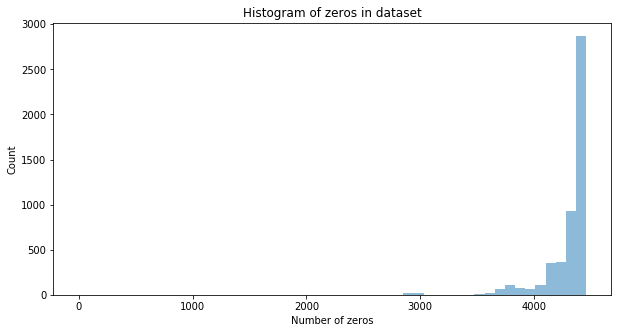

In [37]:
plt.figure(figsize=(10, 5))
plt.hist(number_zeros,bins=50, alpha = 0.5, histtype='bar') # Transactions tend to in X0000 (int)
plt.xlabel('Number of zeros')
plt.ylabel('Count')
plt.title('Histogram of zeros in dataset')
plt.show()

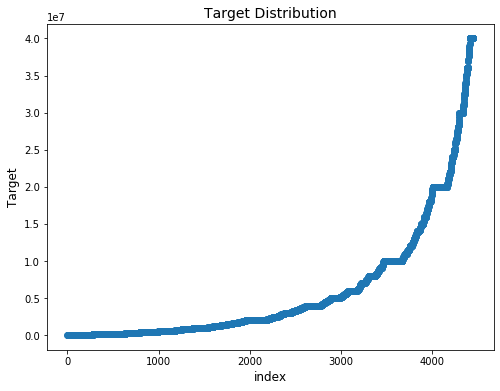

In [38]:
plt.figure(figsize=(8,6))
plt.scatter(range(data.shape[0]), np.sort(data['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

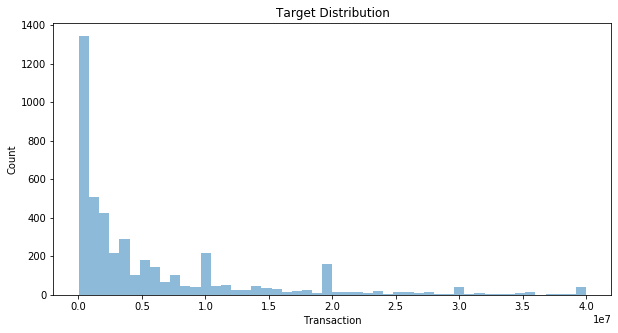

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(data.target,bins=50, alpha = 0.5, histtype='bar') # Transactions tend to in X0000 (int)
plt.xlabel('Transaction')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

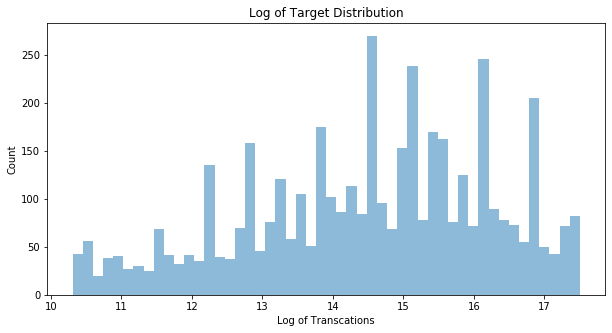

In [40]:

plt.figure(figsize=(10, 5))
plt.hist(target,bins=50, alpha = 0.5, histtype='bar') 
plt.xlabel('Log of Transcations')
plt.ylabel('Count')
plt.title('Log of Target Distribution')
plt.show()

In [43]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

def spearmanr_cal(data):
    col_names = []
    values = []

    for col in data.columns:
        if col not in ['ID','target']:
            col_names.append(col)
            values.append(spearmanr(data[col].values,data.target.values)[0])

    corr_df = pd.DataFrame({'col_names':col_names,'corr_values':values})
    corr_df = corr_df.sort_values(by = 'corr_values')
    return corr_df

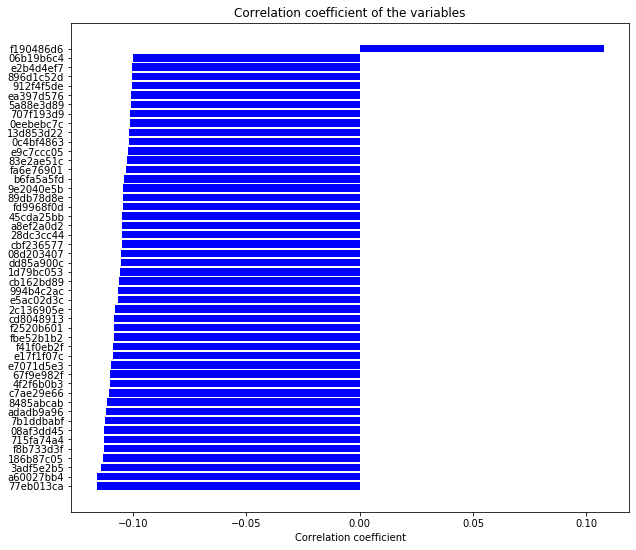

In [50]:
corr_df = spearmanr_cal(data)
high_corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values'] < -0.1)]
ind = np.arange(high_corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,9))
rects = ax.barh(ind, np.array(high_corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(high_corr_df.col_names.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [29]:
high_corr_df.min()

col_names      06b19b6c4
corr_values    -0.116095
dtype: object

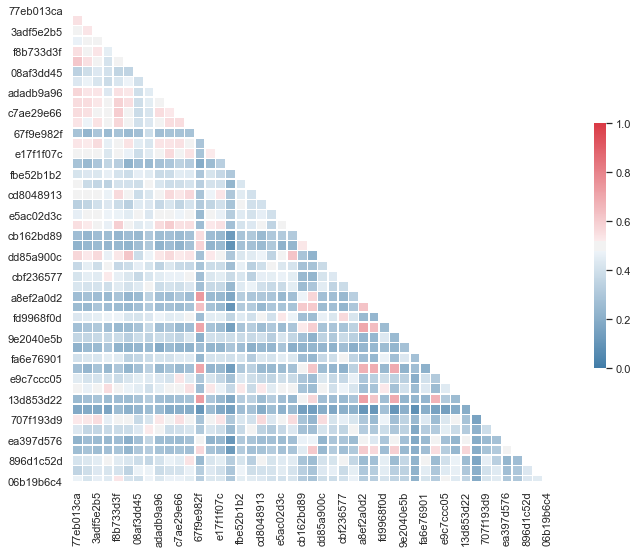

In [43]:
from string import ascii_letters
top_cor_feature = high_corr_df.col_names
sns.set(style="white")
# Compute the correlation matrix
corr_top = data[top_cor_feature].corr(method='spearman')
#corr_high = df[high_corr_col].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_top, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_top, mask=mask, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [90]:
# PCA dimensiuon reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(feat_df.values)
y = np.log1p(data['target'].values)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data[['target']]], axis = 1)
print(pca.explained_variance_ratio_)

[0.02392224 0.02086339]


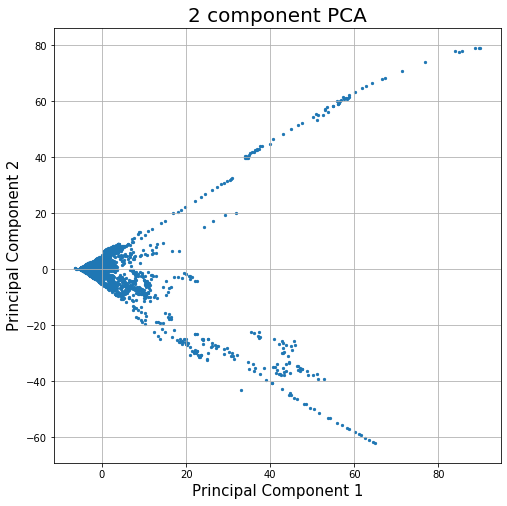

In [91]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(finalDf['principal component 1']
               , finalDf['principal component 2']
               , s = 5)
ax.grid()

In [98]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(x)
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  1527 ;
Total explained variance =  0.95003


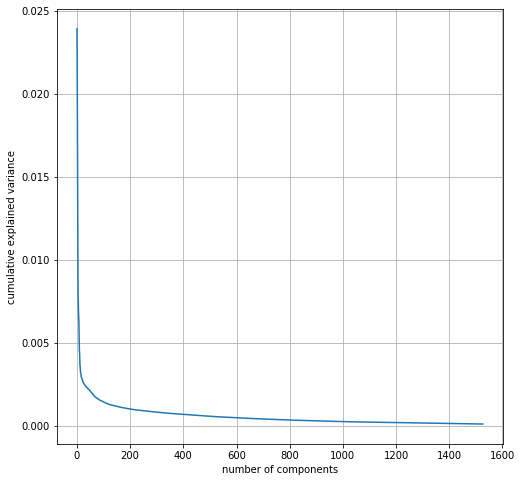

In [99]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.grid()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [109]:
# Do a PCA linear regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x, y
                                                                    ,test_size= 0.2, random_state=137)
pca = PCA(0.95)
pca.fit(X_train_pca)
train_pc = pca.transform(X_train_pca)
test_pc = pca.transform(X_test_pca)

model = LinearRegression()
model.fit(train_pc,y_train_pca)
pred = model.predict(test_pc)
print(f'RMSE is : {sqrt(mean_squared_error(pred, y_test_pca))}')

RMSE is : 1.6376459899080955


In [110]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from functions import *
df,target,df_info = EDA('../input/train.csv')
RANDOM_SEED = 137
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size= test_fraction, random_state=RANDOM_SEED)

best_params_ = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}
 
rf_best = RandomForestRegressor(**best_params_,
                                n_jobs = 8, random_state = RANDOM_SEED)
rf_best.fit(X_train,y_train)

version 5


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
                      oob_score=False, random_state=137, verbose=0,
                      warm_start=False)

In [112]:
evaluate(rf_best, X_test, y_test)

Model Performance
R2 Score: 0.33% degrees.
RMSE = 1.3912


(0.3305878537298953, 1.3911921732133308)

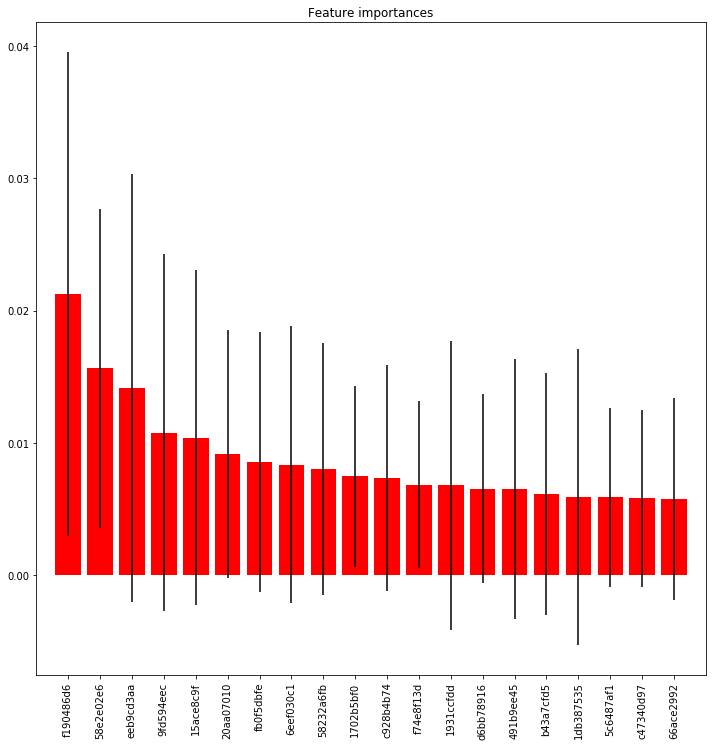

In [113]:
feat_names = X_train.columns.values
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [49]:
feature_sel(rf_best,X_train,y_train)

Index(['20aa07010', '22ed6dba3', '87ffda550', '251d1aa17', '963a49cdc',
       'a75d400b8', '68a945b18', '63c094ba4', '342e7eb03', '4da206d28',
       ...
       'a3fb07bfd', 'b8f892930', 'e79e5f72c', 'a396ceeb9', '4dcf81d65',
       '8781e4b91', 'ef30f6be5', '6df033973', '23310aa6f', '5831f4c76'],
      dtype='object', length=277)


Index(['20aa07010', '22ed6dba3', '87ffda550', '251d1aa17', '963a49cdc',
       'a75d400b8', '68a945b18', '63c094ba4', '342e7eb03', '4da206d28',
       ...
       'a3fb07bfd', 'b8f892930', 'e79e5f72c', 'a396ceeb9', '4dcf81d65',
       '8781e4b91', 'ef30f6be5', '6df033973', '23310aa6f', '5831f4c76'],
      dtype='object', length=277)